# Fake news detection

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [85]:
fake = pd.read_csv("C:/Users/shinj/Downloads/newsdata/Fake.csv")
true = pd.read_csv("C:/Users/shinj/Downloads/newsdata/True.csv")

In [86]:
fake.shape

(23481, 4)

In [87]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [88]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [89]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [90]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [91]:
# Check the data
data.head()

,title,text,subject,date,target
0,Iran rejects U.S. demand for U.N. visit to mil...,ANKARA (Reuters) - Iran has dismissed a U.S. d...,worldnews,"August 29, 2017",true
1,Kurds say reject Iraqi warning to withdraw fro...,BAGHDAD (Reuters) - Kurdish Peshmerga fighters...,worldnews,"October 14, 2017",true
2,DEMOCRAT CHAIRMAN YELLS “All Together Now…F*ck...,The classless Democrats are at it again. The o...,left-news,"May 21, 2017",fake
3,U.N. agrees new team of experts for Burundi bu...,GENEVA (Reuters) - The U.N. Human Rights Counc...,worldnews,"September 28, 2017",true
4,After Charlottesville GOP Asks Supporters How...,"Donald Trump has a massive ego, so much so tha...",News,"August 19, 2017",fake


In [92]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Iran rejects U.S. demand for U.N. visit to mil...,ANKARA (Reuters) - Iran has dismissed a U.S. d...,worldnews,true
1,Kurds say reject Iraqi warning to withdraw fro...,BAGHDAD (Reuters) - Kurdish Peshmerga fighters...,worldnews,true
2,DEMOCRAT CHAIRMAN YELLS “All Together Now…F*ck...,The classless Democrats are at it again. The o...,left-news,fake
3,U.N. agrees new team of experts for Burundi bu...,GENEVA (Reuters) - The U.N. Human Rights Counc...,worldnews,true
4,After Charlottesville GOP Asks Supporters How...,"Donald Trump has a massive ego, so much so tha...",News,fake


In [93]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,ANKARA (Reuters) - Iran has dismissed a U.S. d...,worldnews,true
1,BAGHDAD (Reuters) - Kurdish Peshmerga fighters...,worldnews,true
2,The classless Democrats are at it again. The o...,left-news,fake
3,GENEVA (Reuters) - The U.N. Human Rights Counc...,worldnews,true
4,"Donald Trump has a massive ego, so much so tha...",News,fake


In [94]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,ankara (reuters) - iran has dismissed a u.s. d...,worldnews,true
1,baghdad (reuters) - kurdish peshmerga fighters...,worldnews,true
2,the classless democrats are at it again. the o...,left-news,fake
3,geneva (reuters) - the u.n. human rights counc...,worldnews,true
4,"donald trump has a massive ego, so much so tha...",News,fake


In [95]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [96]:
# Check
data.head()

,text,subject,target
0,ankara reuters iran has dismissed a us demand...,worldnews,true
1,baghdad reuters kurdish peshmerga fighters re...,worldnews,true
2,the classless democrats are at it again the ov...,left-news,fake
3,geneva reuters the un human rights council ag...,worldnews,true
4,donald trump has a massive ego so much so that...,News,fake


In [97]:
!pip install nltk

In [98]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shinj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
data.head()

,text,subject,target
0,ankara reuters iran dismissed us demand united...,worldnews,true
1,baghdad reuters kurdish peshmerga fighters rej...,worldnews,true
2,classless democrats overthetop potty talk chai...,left-news,fake
3,geneva reuters un human rights council agreed ...,worldnews,true
4,donald trump massive ego much claimed several ...,News,fake


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


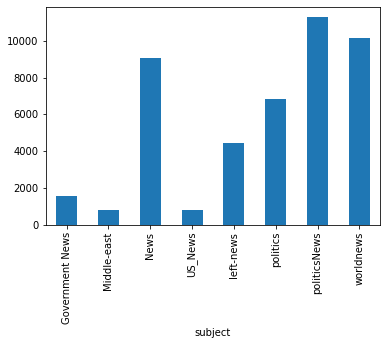

In [100]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


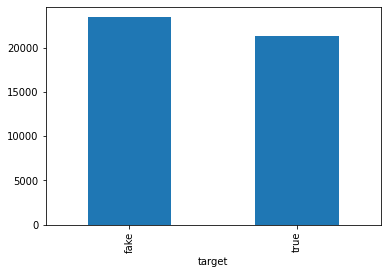

In [101]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [102]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

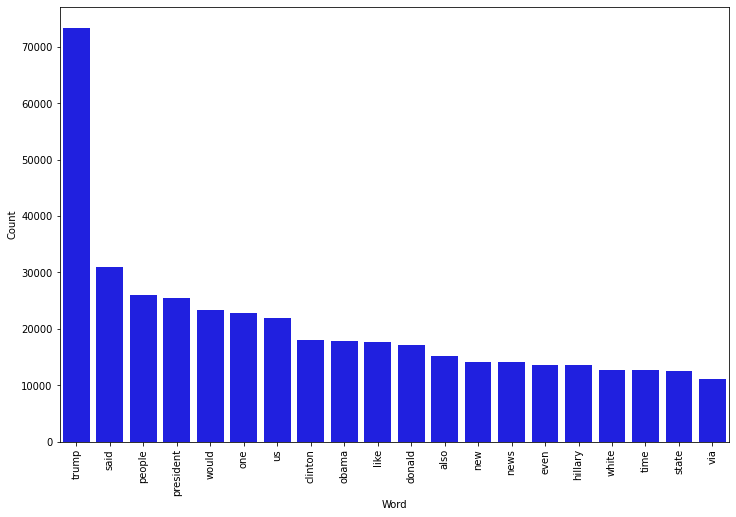

In [103]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

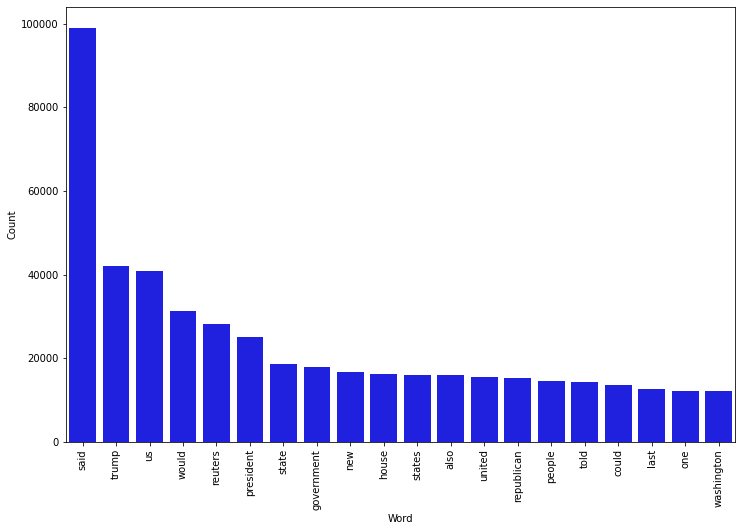

In [104]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [105]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [106]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [107]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


accuracy: 98.85%


In [108]:
#Precision Score
from sklearn.metrics import precision_score
precision_score(y_test, prediction, average='macro')

0.9883865225331633

Confusion matrix, without normalization


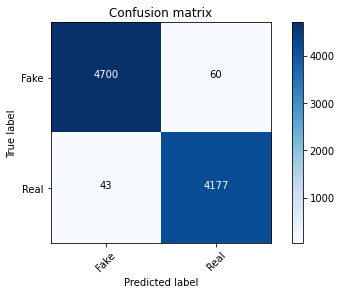

In [109]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [110]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.68%


In [111]:
#Precision Score
precision_score(y_test, prediction, average='macro')

0.9968206017062125

Confusion matrix, without normalization


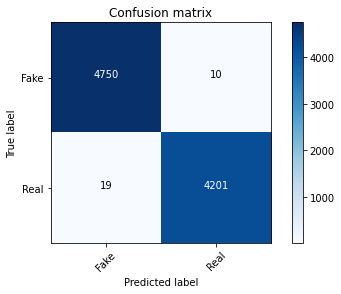

In [112]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [113]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.18%


In [114]:
#Precision Score
precision_score(y_test, prediction, average='macro')

0.9916670399402763

Confusion matrix, without normalization


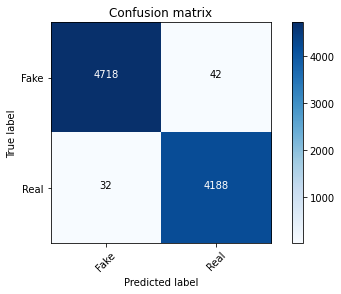

In [115]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Neural Network based approach

In [122]:
import tensorflow as tf

In [123]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [124]:
!pip install imblearn

In [125]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size = 0.3, stratify = data['target'])

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [127]:
coo = X_train_vect.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
X_train_vector=tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))


In [128]:
coo=X_test_vect.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
X_test_vector=tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))


In [129]:
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier


def build_model():
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_vect.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

estimator = KerasClassifier(build_fn=build_model, epochs=5, batch_size=128)

In [130]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [131]:
estimator.fit(X_train_vector,y_train)

Epoch 1/5


C:\Users\shinj\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_8/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_8/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_8/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


246/246 [==============================] - 91s 361ms/step - loss: 0.1003 - accuracy: 0.9680
Epoch 2/5
246/246 [==============================] - 87s 355ms/step - loss: 0.0045 - accuracy: 0.9990
Epoch 3/5
246/246 [==============================] - 88s 359ms/step - loss: 5.2819e-04 - accuracy: 0.9999
Epoch 4/5
246/246 [==============================] - 88s 356ms/step - loss: 5.2461e-04 - accuracy: 0.9998
Epoch 5/5
246/246 [==============================] - 88s 358ms/step - loss: 8.2914e-04 - accuracy: 0.9999


C:\Users\shinj\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        fake     0.9964    0.9921    0.9942      7045
        true     0.9913    0.9961    0.9937      6425

    accuracy                         0.9940     13470
   macro avg     0.9939    0.9941    0.9940     13470
weighted avg     0.9940    0.9940    0.9940     13470



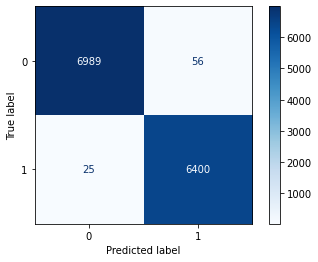

In [132]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
nn_pred = estimator.predict(X_test_vector)
nn_cr = classification_report(y_test, nn_pred, digits = 4)
print(nn_cr)

nn_cm = confusion_matrix(y_test, nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = nn_cm, display_labels = [0,1])
disp = disp.plot(cmap = "Blues")
plt.show()

In [133]:
type(X_test)


pandas.core.series.Series

In [134]:
nn_pred

array([['fake'],
       ['true'],
       ['true'],
       ...,
       ['true'],
       ['fake'],
       ['fake']], dtype=object)

In [136]:
print("Accuracy:",accuracy_score(y_test,estimator.predict(X_test_vector))*100,"%")

C:\Users\shinj\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 99.39866369710467 %
